# Infection Rate Calibration

Based on a fixed network model, we sweep over the infection rate parameter $\beta$ to find the one that minimizes a point process distance between realizations of simulated processes and the real time series.

The distance chosen for this task is ...

In [1]:
%load_ext autoreload
%autoreload 2

In [230]:
from matplotlib import pyplot as plt
%matplotlib inline

import os
import json
import itertools
from collections import Counter, defaultdict
import pandas as pd
import networkx as nx


from lib.graph_generation import make_ebola_network
from lib.dynamics import SimulationSIR, PriorityQueue
from lib.dynamics import sample_seeds
from lib.settings import DATA_DIR
from lib import metrics

---

## Set simulation parameters

Set time

In [381]:
start_day_str = '2014-01-01'
end_day_str = '2014-03-01'
max_timedelta = pd.to_datetime(end_day_str) - pd.to_datetime(start_day_str)
max_days = max_timedelta.days

Set SIR infection and recovery rates

In [227]:
beta = 1 / 15.3
delta = 1 / 11.4

Network parameters

In [452]:
n_sims = 100
n_graphs = 50

res_list = list()

n_nodes = 8000
p_in = 0.01

# Inter-district edge probability to experiment with
p_out_range = {
           'Guinea': [0.00165, ], 
          'Liberia': [0.0022, ], 
     'Sierra Leone': [0.0027, ], 
    'inter-country': 0.002
}

---

## Run calibration


In [457]:
def worker(graph):
    for i in range(n_sims):

        # print(f'\rExp {p_idx+1}/{n_p_out} - Graph {j+1}/{n_graphs} - Sim {i+1}/{n_sims}', end='    ')

        # === Sample initial seeds

        init_event_list = sample_seeds(graph, delta=delta, 
                                       method='random', n_seeds=10, 
                                       verbose=False)

        seed_node_list = np.array(list(set([event[0] for event,_ in init_event_list])))
        seed_neighbors_list = np.hstack([list(graph.neighbors(u)) for u in seed_node_list])

        seed_ego_net = nx.subgraph(graph, np.hstack((seed_node_list, seed_neighbors_list)))

        def stop_criteria(sir_obj):
            seed_node_indices = np.array([sir_obj.node_to_idx[u] for u in seed_node_list])
            seed_neighbors_indices = np.array([sir_obj.node_to_idx[u] for u in seed_neighbors_list])
            return np.all(sir_obj.is_rec[seed_node_indices]) or np.all(sir_obj.is_inf[seed_neighbors_indices])

        # === Run simulation 

        sir_obj = SimulationSIR(seed_ego_net, beta=beta, delta=delta, gamma=0.0, rho=0.0, verbose=False)
        sir_obj.launch_epidemic(
            init_event_list=init_event_list,
            max_time=max_days, 
            policy='NO', 
            stop_criteria=stop_criteria
        )

        # === Compute R0

        infector_count = Counter(sir_obj.infector)

        country_count = defaultdict(list)
        for u in seed_node_list:
            u_idx = sir_obj.node_to_idx[u]
            u_country = sir_obj.G.node[u]['country']
            inf_count = infector_count[u_idx]
            country_count[u_country].append(inf_count)

        for country, count in country_count.items():
            res_list.append({
                'country': country,
                'sim_idx': i, 'net_idx': j,
                'p_idx': p_idx,
                'p_out_gn': p_out_gn,
                'p_out_lb': p_out_lb, 
                'p_out_sl': p_out_sl,
                'count': count
            })
    return res_list

In [455]:

# Iterate over infection rates
p_out_range_product = list(itertools.product(
    p_out_range['Guinea'], 
    p_out_range['Liberia'], 
    p_out_range['Sierra Leone']
))
n_p_out = len(p_out_range_product)


for p_idx, (p_out_gn, p_out_lb, p_out_sl) in enumerate(p_out_range_product):

    p_out = {
               'Guinea': p_out_gn, 
              'Liberia': p_out_lb, 
         'Sierra Leone': p_out_sl, 
        'inter-country': 0.0040
    }

    for j in range(n_graphs):

        graph = make_ebola_network(n_nodes=n_nodes, p_in=p_in, p_out=p_out)


print()

Exp 1/1 - Graph 30/30 - Sim 100/100        


In [456]:
res_df = pd.DataFrame(res_list)

# Aggregate results by country and graph to get R0 estimate per country and graph
res_df_gp = res_df.groupby(
    ['country',
     'net_idx',
    ]
).agg(
    {'count': list}
)['count'].apply(np.hstack).apply(np.mean).reset_index()

# Aggregate results by graph to get uncertainty over R0 per country
res_df_country_gp = pd.DataFrame(res_df_gp.groupby('country')['count'].agg(list))

res_df_country_gp['mean'] = res_df_country_gp['count'].apply(np.mean)
res_df_country_gp['std'] = res_df_country_gp['count'].apply(np.std)
res_df_country_gp['Q5'] = res_df_country_gp['count'].apply(lambda a: np.percentile(a, q=5))
res_df_country_gp['Q95'] = res_df_country_gp['count'].apply(lambda a: np.percentile(a, q=95))
del res_df_country_gp['count']

res_df_country_gp

,mean,std,Q5,Q95
country,,,,
Guinea,1.722708,0.059479,1.642437,1.824013
Liberia,1.812407,0.091569,1.676116,1.953550
Sierra Leone,1.997731,0.065988,1.909955,2.128491


---

R0 per country:
         Guinea  1.6856
        Liberia  1.8530
   Sierra Leone  2.2720


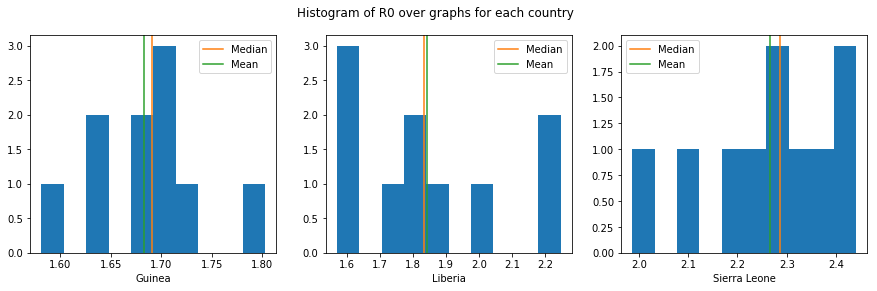

In [220]:
print('R0 per country:')
for k, v in res_dict.items():
    print(f"{k:>15s}  {np.mean(np.hstack(v.flatten())):.4f}")    
    
fig, axs = plt.subplots(1, len(res_dict), figsize=(15, 4))
fig.suptitle('Histogram of R0 over graphs for each country')
for i, (k, v) in enumerate(res_dict.items()):
    rt_country_list = list()
    for j in range(n_graphs):
        rt_j = np.mean(np.hstack(v[:,j]))
        rt_country_list.append(rt_j)
    axs[i].hist(rt_country_list)
    axs[i].set_xlabel(k)
    axs[i].axvline(np.median(rt_country_list), c='C1', label='Median')
    axs[i].axvline(np.mean(rt_country_list), c='C2', label='Mean')
    axs[i].legend()

---

In [403]:
n_nodes = 8000
p_in = 0.04

# Inter-district edge probability to experiment with
p_out = {
           'Guinea': 0.00478, 
          'Liberia': 0.00510, 
     'Sierra Leone': 0.00485,
    'inter-country': 0.0040
}

graph = make_ebola_network(n_nodes=n_nodes, p_in=p_in, p_out=p_out)

init_event_list = sample_seeds(graph, delta=delta, 
                               method='data', max_date=start_day_str,
                               verbose=False)
   
sir_obj = SimulationSIR(graph, beta=beta, delta=delta, gamma=0.0, rho=0.0, verbose=True)
sir_obj.launch_epidemic(
    init_event_list=init_event_list,
    max_time=40, 
    policy='NO'
)


Epidemic stopped after 40.00 days | 5703 sus., 958 inf., 930 rec., 0 tre (0.00% of inf) | I(q): 4089 R(q): 958 T(q): 0 |q|: 5047


<BarContainer object of 39 artists>

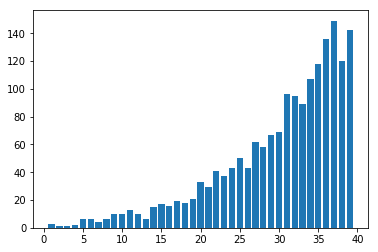

In [404]:
daily_count_arr, bins = np.histogram(
    sir_obj.inf_occured_at[(sir_obj.inf_occured_at < np.inf) & (sir_obj.inf_occured_at > 0)], 
    bins=np.arange(0, sir_obj.max_time)
)
plt.bar(bins[1:], daily_count_arr)

In [405]:
daily_count_arr

array([  3,   1,   1,   2,   6,   6,   4,   6,  10,  10,  13,  10,   6,  15,  17,  16,  19,  18,  21,  33,  29,  41,  37,  43,  50,  43,  62,  58,  67,  69,  96,  95,  89, 107, 118, 136, 149, 120, 142])

In [406]:
rt_list = [metrics.estimate_reproduction_number(daily_count_arr[i:i+30], beta, T=30) for i in range(int(sir_obj.max_time) - 30)]

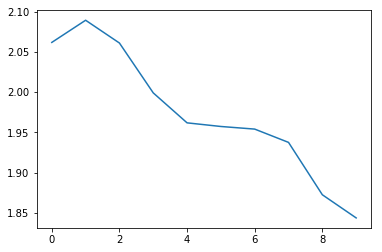

In [407]:
plt.plot(rt_list)

In [408]:
rt_list

[2.0616796713253533,
 2.089209503447175,
 2.0609164517559657,
 1.999026492258987,
 1.9618309785805825,
 1.9573192198692413,
 1.9540754661370725,
 1.937564950668573,
 1.8725576288931935,
 1.843808666882789]